In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import datetime as dt
import math
import time
import re   
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import quantstats
plt.style.use('ggplot')
os.chdir("C:/Users/ss871/OneDrive/桌面/python/Quant/DATA")

處理資料

In [2]:
history_turnover = pd.read_csv("History_turnover.csv", encoding='cp950')
history_turnover['年月'] = pd.to_datetime(history_turnover['年月'], format='%Y%m')
history_turnover = history_turnover.set_index(['證券代碼','年月'])

In [4]:
df = pd.read_csv("20231014060035.csv", encoding='cp950')
df['年月'] = pd.to_datetime(df['年月'], format='%Y%m')
df=df.set_index(['證券代碼','年月'])

In [6]:
k = 9
df_turnover = df.unstack()["週轉率％_月"].drop(columns=df.unstack()["週轉率％_月"].columns[0:k-1])
df_turnover.fillna(0,inplace=True)
df_return = df.unstack()["報酬率％_月"].drop(columns=df.unstack()["報酬率％_月"].columns[0:k-1])
df_return.fillna(-100,inplace=True)
return_m=df.groupby(level=0).rolling(window=k).mean()['報酬率％_月']
return_m=return_m.unstack()
return_m=return_m.reset_index(level=0,drop=True)
return_m=return_m.fillna(0)
#return_m.drop(columns=['2015-10-01',"2015-11-01"], inplace = True)
return_m.drop(return_m.columns[range(0,k-1)], axis=1, inplace=True)


回測架構

In [7]:
s = 0
n = 20
a = len(df_return.columns)
b = len(range(s,n))

portfolio_list = {}
for i in range(len(df_turnover.columns)): 
    profit=0
    large = []
    small = []
    return_ = []
    fliter = history_turnover.index.get_level_values('年月') <= str(df_turnover.columns[i])
    median_turnover = history_turnover[fliter].groupby(level = 0)['週轉率％_月'].median()
    for security in df_turnover.index:
        if security in median_turnover.index and security in return_m.index:
            if df_turnover.loc[security].iloc[i] > median_turnover.loc[security]:
                large.append(security)  
            elif df_turnover.loc[security].iloc[i] < median_turnover.loc[security] and df_turnover.loc[security].iloc[i] != 0: 
                small.append(security)
    for j in large:
        return_.append(return_m.loc[j].iloc[i])
    portfolio = pd.DataFrame({"Security":large, "AVG_Return":return_})
    portfolio = portfolio.set_index("Security")
    portfolio = portfolio.sort_values(by="AVG_Return",ascending = False)[s:n]
    portfolio_list[str(df_turnover.columns[i])] = portfolio.index
portfolio_list = pd.DataFrame(portfolio_list) 


全樣本

In [8]:
initial_fund=10000
fund = 0
keep = {} #上個月和這個月相同的股票及其金額 
sell = {} #上個月和這個月不相同的股票及其金額
stock = {} #所有選到的股票和其金額
position_list = [initial_fund/b]
profit_list=[initial_fund]
fee = 1
for i in range(len(df_turnover.columns)):
    
    hold = []
    sold = []
    profit = 0
    hold1 = 0  #下個月不須售出個股的金額相加總
    sold1 = 0  #下個月須售出個股的金額相加總
    money_sold = 0  
    position = 0
    if i == 0:
        for security in portfolio_list.iloc[:,0]:
            hold2 = 0 #下個月不須售出個股的金額
            sold2 = 0 #下個月須售出個股的金額
            is_in_column2 = security in portfolio_list.iloc[:,1].values  ##這個月選到的股票在下個月是否也會選到
            if is_in_column2 == True:
                hold2 = position_list[0]*((df_return.loc[security].iloc[1])/100+1)
                hold1 += hold2
                hold.append([security,hold2])
            else:
                sold2 = (initial_fund//b)*((df_return.loc[security].iloc[1])/100+1) * fee
                sold1 += sold2
                sold.append([security,sold2])
        keep[str(df_turnover.columns[0])] = hold
        sell[str(df_turnover.columns[0])] = sold
        stock[str(df_turnover.columns[0])] = hold + sold
        profit = hold1 + sold1
        profit_list.append(profit)
    if i != 0 and i != a-1:

        for k in sell[str(df_turnover.columns[i-1])]: #k是要上個月的股票需要賣掉的
            money_sold += k[1] ## 將要賣掉的股票金額通通加起來

        position = money_sold // len(sell[str(df_turnover.columns[i-1])])  #這個月可以每檔股票可以買的金額
        position_list.append(position)
        stock1=[] ##該月的所有股票


        for security in portfolio_list.iloc[:,i]: #該月投資組合名單 
            sold2 = 0
            hold2 = 0

            is_in_column2 = security in portfolio_list.iloc[:,i-1].values  #這個月投組是否和上個月有重複的
            if is_in_column2 == False:
            ##從這裡開始，用for迴圈試試看對應到的hold股票
                sold2 = position * ((df_return.loc[security].iloc[i+1])/100+1)
                sold1 += sold2
                stock1.append((security,sold2))
        
            else:
                for j in keep[str(df_turnover.columns[i-1])]:
                    if j[0] == security:
                        hold2 = ((df_return.loc[security].iloc[i+1])/100+1) * j[1] #這個月若在上個月裡
                        hold1 += hold2
                        stock1.append((security,hold2))
                

        stock[str(df_turnover.columns[i])] = stock1


        for security in portfolio_list.iloc[:,i]:
            is_in_column = security in portfolio_list.iloc[:,i+1].values
            if is_in_column == True:
                for k in stock[str(df_turnover.columns[i])]:
                    if security == k[0]:
                        hold.append(k)
            else:
                for k in stock[str(df_turnover.columns[i])]:
                    if security == k[0]:
                        sold.append(k)
        keep[str(df_turnover.columns[i])] = hold
        sell[str(df_turnover.columns[i])] = sold
        stock[str(df_turnover.columns[i])] = hold + sold
        profit = hold1 + sold1
        profit_list.append(profit)


In [9]:
initial_fund=10000
fund = 0
keep = {} #上個月和這個月相同的股票及其金額 
sell = {} #上個月和這個月不相同的股票及其金額
stock = {} #所有選到的股票和其金額
position_list = [initial_fund/b]
profit_fee_list=[initial_fund]
fee = 0.97
for i in range(len(df_turnover.columns)):
    
    hold = []
    sold = []
    profit = 0
    hold1 = 0  #下個月不須售出個股的金額相加總
    sold1 = 0  #下個月須售出個股的金額相加總
    money_sold = 0  
    position = 0
    if i == 0:
        for security in portfolio_list.iloc[:,0]:
            hold2 = 0 #下個月不須售出個股的金額
            sold2 = 0 #下個月須售出個股的金額
            is_in_column2 = security in portfolio_list.iloc[:,1].values  ##這個月選到的股票在下個月是否也會選到
            if is_in_column2 == True:
                hold2 = position_list[0]*((df_return.loc[security].iloc[1])/100+1) * fee
                hold1 += hold2
                hold.append([security,hold2])
            else:
                sold2 = (initial_fund//b)*((df_return.loc[security].iloc[1])/100+1) * fee
                sold1 += sold2
                sold.append([security,sold2])
        keep[str(df_turnover.columns[0])] = hold
        sell[str(df_turnover.columns[0])] = sold
        stock[str(df_turnover.columns[0])] = hold + sold
        profit = hold1 + sold1
        profit_fee_list.append(profit)
    if i != 0 and i != a-1:

        for k in sell[str(df_turnover.columns[i-1])]: #k是要上個月的股票需要賣掉的
            money_sold += k[1] ## 將要賣掉的股票金額通通加起來

        position = money_sold // len(sell[str(df_turnover.columns[i-1])])  #這個月可以每檔股票可以買的金額
        position_list.append(position)
        stock1=[] ##該月的所有股票


        for security in portfolio_list.iloc[:,i]: #該月投資組合名單 
            sold2 = 0
            hold2 = 0

            is_in_column2 = security in portfolio_list.iloc[:,i-1].values  #這個月投組是否和上個月有重複的
            if is_in_column2 == False:
            ##從這裡開始，用for迴圈試試看對應到的hold股票
                sold2 = position * ((df_return.loc[security].iloc[i+1])/100+1) * fee
                sold1 += sold2
                stock1.append((security,sold2))
        
            else:
                for j in keep[str(df_turnover.columns[i-1])]:
                    if j[0] == security:

                        hold2 = ((df_return.loc[security].iloc[i+1])/100+1) * j[1] #這個月若在上個月裡
                        hold1 += hold2
                        stock1.append((security,hold2))
                

        stock[str(df_turnover.columns[i])] = stock1


        for security in portfolio_list.iloc[:,i]:
            is_in_column = security in portfolio_list.iloc[:,i+1].values
            if is_in_column == True:
                for k in stock[str(df_turnover.columns[i])]:
                    if security == k[0]:
                        hold.append(k)
            else:
                for k in stock[str(df_turnover.columns[i])]:
                    if security == k[0]:
                        sold.append(k)
        keep[str(df_turnover.columns[i])] = hold
        sell[str(df_turnover.columns[i])] = sold
        stock[str(df_turnover.columns[i])] = hold + sold
        profit = hold1 + sold1
        profit_fee_list.append(profit)


全樣本績效

In [17]:
equity = pd.DataFrame({'profit': profit_list,
                      'profitfee': profit_fee_list}, index= df_return.columns)
equity=equity-initial_fund
equity['equity']=equity['profitfee'] + initial_fund
equity['drawdown_percent'] = (equity['equity'] / equity['equity'].cummax()) - 1
equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
high_index = equity[equity['profitfee'].cummax() == equity['profitfee']].index
new_high = equity[equity['profitfee'].cummax() == equity['profitfee']]

In [18]:
m_profit = []
for i in range(len(equity['equity'])):
    if i == 0:
        m_profit.append(0)
    else:
        m_profit.append(equity['equity'].iloc[i]-equity['equity'].iloc[i-1])
equity['m_profit'] = np.round(m_profit,4)
monthly_ret = []
for i in range(len(equity['equity'])):
    if i == 0:
        monthly_ret.append(0)
    else:
        monthly_ret.append(equity['equity'].iloc[i]/equity['equity'].iloc[i-1]-1)
equity['m_return'] = np.round(monthly_ret,4)


In [19]:
date = "2021-06-01"
insample_condition = equity.index < date
outsample_condition = equity.index >= date
insample = equity[insample_condition]
outsample = equity[outsample_condition]


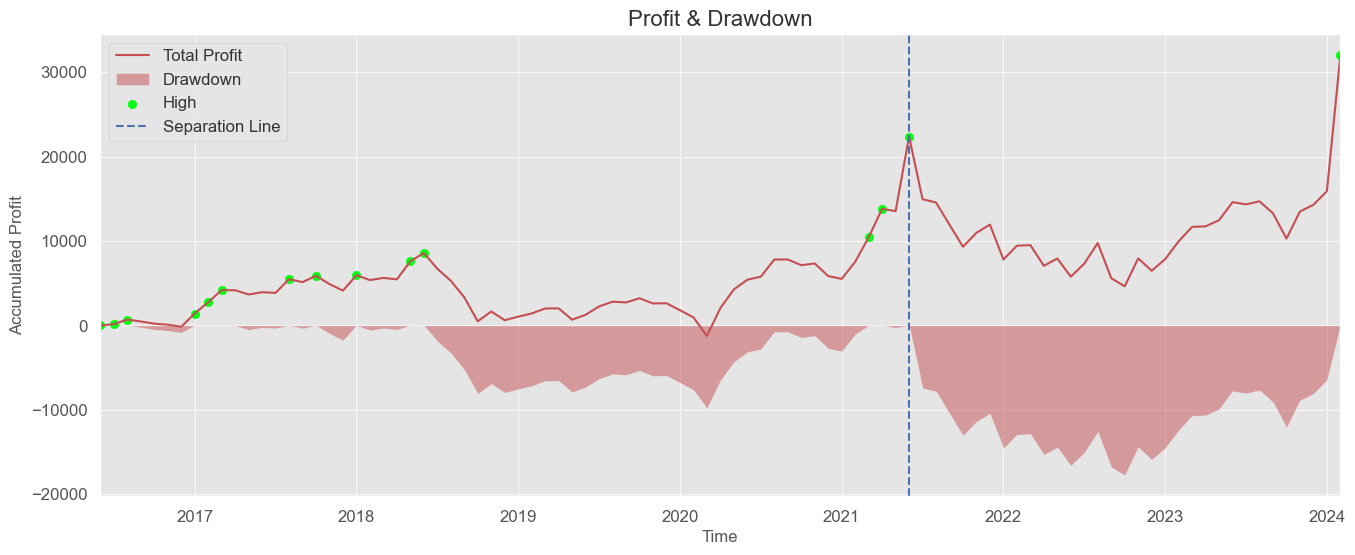

In [20]:
fig, ax = plt.subplots(figsize=(16, 6))
equity['profitfee'].plot(label='Total Profit', ax=ax, c='r', grid=True)
plt.fill_between(equity['drawdown'].index, equity['drawdown'],
                 0, facecolor='r', label='Drawdown', alpha=0.5)
plt.scatter(
    high_index, equity['profitfee'].loc[high_index], c='#02ff0f', label='High')

date = "2021-06-01"
plt.axvline(x = date, color = "b", linestyle = "--", label='Separation Line')
plt.legend()
plt.ylabel('Accumulated Profit')
plt.xlabel('Time')
plt.title('Profit & Drawdown', fontsize=16)
plt.savefig("'Profit & Drawdown'.jpg")
plt.show()


全樣本績效

In [21]:
all_sample_ret = equity['equity'].pct_change(periods=1).dropna()
def cal_sharp(monthly_returns : np.ndarray, rf = 0, periods = 12):
    Er = monthly_returns.sum() / len(monthly_returns) - rf / periods
    sharp = Er/monthly_returns.std() * math.sqrt(periods)
    return sharp

def cal_volatility(monthly_ret : np.ndarray, periods = 12):
    vol = np.sqrt(periods) * np.std(monthly_ret)
    return vol


In [22]:
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0]
mdd = abs(equity['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(equity)-1
winRate = len([i for i in equity['m_return'] if i > 0]) / len(equity['m_return'])
profitFactor = sum([i for i in equity['m_profit'] if i > 0]) / abs(sum([i for i in equity['m_profit'] if i < 0]))
winLossRatio = np.mean([i for i in equity['m_profit'] if i > 0]) / abs(np.mean([i for i in equity['m_profit'] if i < 0]))
cagr = (equity['equity'][-1]/initial_fund) **(1/9.683) -1
print(f'profit: ${np.round(profit,2)}')
print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'volatility: {np.round(cal_volatility(all_sample_ret),2)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'sharpRatio: {np.round(cal_sharp(all_sample_ret),2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100:.2f}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'CAGR: {cagr * 100:.2f}%')

profit: $32026.26
return: 420.26000000000005%
mdd: 54.800000000000004%
volatility: 44.0%
calmarRatio: 7.67
sharpRatio: 0.63
tradeTimes: 92
winRate: 55.91%
profitFactor: 1.58
winLossRatio: 1.22
CAGR: 15.98%


樣本內績效

In [23]:
profit = insample['profitfee'].iloc[-1]
ret = insample['equity'][-1]/insample['equity'][0]
mdd = abs(insample['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(insample)-1
winRate = len([i for i in insample['m_return'] if i > 0]) / len(insample['m_return'])
profitFactor = sum([i for i in insample['m_profit'] if i > 0]) / abs(sum([i for i in insample['m_profit'] if i < 0]))
winLossRatio = np.mean([i for i in insample['m_profit'] if i > 0]) / abs(np.mean([i for i in insample['m_profit'] if i < 0]))
cagr = (insample['equity'][-1]/initial_fund) **(1/7) -1

print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'volatility: {np.round(cal_volatility(all_sample_ret),2)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'sharpRatio: {np.round(cal_sharp(all_sample_ret),2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100:.2f}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'CAGR: {cagr * 100:.2f}%')

return: 235.49%
mdd: 52.83%
volatility: 44.0%
calmarRatio: 4.46
sharpRatio: 0.63
tradeTimes: 59
winRate: 53.33%
profitFactor: 1.61
winLossRatio: 1.36
CAGR: 13.02%


樣本外績效

In [24]:
profit = outsample['profitfee'].iloc[-1]-outsample['profitfee'].iloc[0]
ret = outsample['equity'][-1]/outsample['equity'][0]
mdd = abs(outsample['drawdown_percent'].min())
calmarRatio = ret / mdd
tradeTimes = len(outsample)-1
winRate = len([i for i in outsample['m_return'] if i > 0]) / len(outsample['m_return'])
profitFactor = sum([i for i in outsample['m_profit'] if i > 0]) / abs(sum([i for i in outsample['m_profit'] if i < 0]))
winLossRatio = np.mean([i for i in outsample['m_profit'] if i > 0]) / abs(np.mean([i for i in outsample['m_profit'] if i < 0]))
cagr = (outsample['equity'][-1]/outsample['equity'][0]) ** (1/2.7) -1

print(f'return: {np.round(ret,4)*100}%')
print(f'mdd: {np.round(mdd,4)*100}%')
print(f'volatility: {np.round(cal_volatility(all_sample_ret),2)*100}%')
print(f'calmarRatio: {np.round(calmarRatio,2)}')
print(f'sharpRatio: {np.round(cal_sharp(all_sample_ret),2)}')
print(f'tradeTimes: {tradeTimes}')
print(f'winRate: {np.round(winRate,4)*100:.2f}%')
print(f'profitFactor: {np.round(profitFactor,2)}')
print(f'winLossRatio: {np.round(winLossRatio,2)}')
print(f'CAGR: {cagr * 100:.2f}%')

return: 129.75%
mdd: 54.800000000000004%
volatility: 44.0%
calmarRatio: 2.37
sharpRatio: 0.63
tradeTimes: 32
winRate: 60.61%
profitFactor: 1.56
winLossRatio: 1.01
CAGR: 10.13%
